# **UEFA Champions League predicciones**

### En este archivo trataremos con diferentes modelos de predicción para predecir el ganador del torneo de fútbol de esta temporada 23-24.

Comenzamos importando todas las dependecias necesarias para el correcto funcionamiento del documento, aunque primero hay que asegurarnos que las tenemos instaladas.

In [1]:
# Importamos librerías

# Visualización de datos
%matplotlib inline

# Manipulación de datos
import pandas as pd
from pandas.plotting import scatter_matrix
from itertools import groupby

# Preparación de los datos
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

# Modelos de predicción
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Métricas de evaluación
from sklearn.metrics import accuracy_score, classification_report

El siguiente paso es importar los datos con lo que vamos a trabajar.

In [2]:
overall = pd.read_csv('../data/overall_limpio.csv')
overall.head()

,Season,Rk,Squad,Country,MP,W,D,L,GF,GA,GD,Pts,Attendance,Top Team Scorer,Goalkeeper,Top Team Scorer Goals
0,2023-2024,QF,Manchester City,Inglaterra,8.0,8.0,0.0,0.0,24.0,9.0,15.0,24.0,51047.0,Erling Haaland,Ederson,6.0
1,2023-2024,QF,Real Madrid,España,8.0,7.0,1.0,0.0,18.0,8.0,10.0,22.0,70851.0,Jude Bellingham,"Kepa Arrizabalaga,Andriy Lunin",4.0
2,2023-2024,QF,Bayern Munich,Alemania,8.0,6.0,1.0,1.0,15.0,7.0,8.0,19.0,75000.0,Harry Kane,Manuel Neuer,6.0
3,2023-2024,QF,Atlético Madrid,España,8.0,5.0,2.0,1.0,19.0,8.0,11.0,17.0,63844.0,Antoine Griezmann,Jan Oblak,6.0
4,2023-2024,QF,Arsenal,Inglaterra,8.0,5.0,1.0,2.0,17.0,5.0,12.0,16.0,59782.0,Gabriel Jesus,David Raya,4.0


### Exploración de datos

Hacemos unos pequeños ajustes a los datos antes de hacer las predicciones. Como por ejemplo, eliminar aquellas filas vacías.

In [3]:
# Eliminamos las filas que contienen valores nulos
overall = overall.dropna()

Visualizamos los datos para poder analizar como de relacionadas están las columnas numéricas entre ellas.

array([[<AxesSubplot:xlabel='MP', ylabel='MP'>,
        <AxesSubplot:xlabel='W', ylabel='MP'>,
        <AxesSubplot:xlabel='D', ylabel='MP'>,
        <AxesSubplot:xlabel='L', ylabel='MP'>,
        <AxesSubplot:xlabel='GF', ylabel='MP'>,
        <AxesSubplot:xlabel='GA', ylabel='MP'>,
        <AxesSubplot:xlabel='GD', ylabel='MP'>,
        <AxesSubplot:xlabel='Pts', ylabel='MP'>,
        <AxesSubplot:xlabel='Attendance', ylabel='MP'>,
        <AxesSubplot:xlabel='Top Team Scorer Goals', ylabel='MP'>],
       [<AxesSubplot:xlabel='MP', ylabel='W'>,
        <AxesSubplot:xlabel='W', ylabel='W'>,
        <AxesSubplot:xlabel='D', ylabel='W'>,
        <AxesSubplot:xlabel='L', ylabel='W'>,
        <AxesSubplot:xlabel='GF', ylabel='W'>,
        <AxesSubplot:xlabel='GA', ylabel='W'>,
        <AxesSubplot:xlabel='GD', ylabel='W'>,
        <AxesSubplot:xlabel='Pts', ylabel='W'>,
        <AxesSubplot:xlabel='Attendance', ylabel='W'>,
        <AxesSubplot:xlabel='Top Team Scorer Goals', ylabel='W'>]

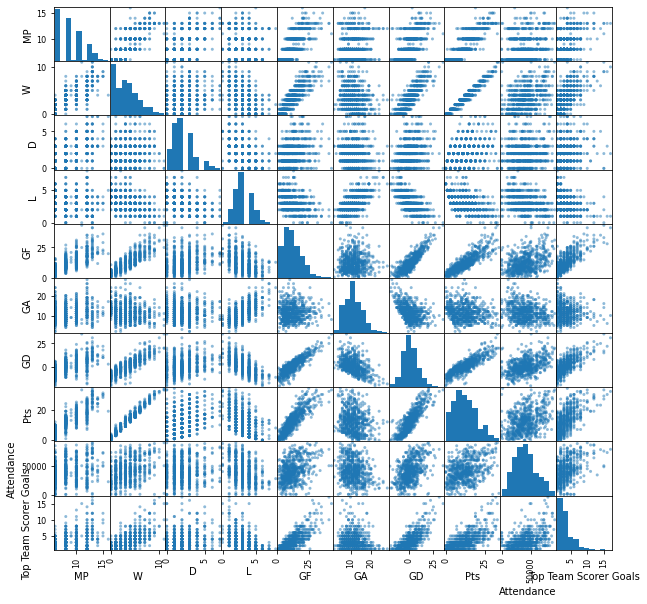

In [4]:
scatter_matrix(overall[['MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Attendance', 'Top Team Scorer Goals']], figsize=(10,10))

### Preparación de los datos.

Ahora ya definimos nuestras variables para las predicciones. En nuestro caso, queremos predecir los resultados del torneo, por que querremos predecir la columna 'Rk' que muestra los rankings.

In [5]:
X = overall.drop(labels=['Rk'], axis=1)
y = overall['Rk']

# Estandarizamos los datos

# Columnas a estandarizar
cols = [['MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Attendance', 'Top Team Scorer Goals']]

# Se recorren las columnas especificadas y se escala cada una
for col in cols:
    X[col] = scale(X[col])

Queremos variables continuas que sean enteras para nuestros datos de entrada, así que eliminemos cualquier variable categórica pasándo las variables a dummy.

In [6]:
X_dummy = pd.get_dummies(X)
X_dummy.head()

,MP,W,D,L,GF,GA,GD,Pts,Attendance,Top Team Scorer Goals,...,Goalkeeper_Wojciech Kowalewski,Goalkeeper_Wojciech Szczęsny,Goalkeeper_Yann Sommer,Goalkeeper_Yassine Bounou,Goalkeeper_Yuri Lodygin,Goalkeeper_Zeljko Kalac,Goalkeeper_Álex Remiro,Goalkeeper_Óscar Córdoba,Goalkeeper_Đorđe Pantić,Goalkeeper_Łukasz Fabiański
0,-0.232683,1.980442,-1.445300,-2.318774,1.614623,-0.616636,1.740019,1.597006,0.569057,0.971753,...,0,0,0,0,0,0,0,0,0,0
1,-0.232683,1.550283,-0.764301,-2.318774,0.774891,-0.863593,1.120073,1.323771,1.625083,0.163195,...,0,0,0,0,0,0,0,0,0,0
2,-0.232683,1.120124,-0.764301,-1.560914,0.355024,-1.110550,0.872095,0.913918,1.846324,0.971753,...,0,0,0,0,0,0,0,0,0,0
3,-0.232683,0.689965,-0.083303,-1.560914,0.914846,-0.863593,1.244062,0.640683,1.251443,0.971753,...,0,0,0,0,0,0,0,0,0,0
4,-0.232683,0.689965,-0.764301,-0.803054,0.634935,-1.604463,1.368052,0.504065,1.034841,0.163195,...,0,0,0,0,0,0,0,0,0,0


Queremos entrenar nuestro modelo con los datos de las temporadas anteriores. Una vez hecho el modelo y evaluado, haremos las predicciones con los datos de la temporada actual 2023-2024.

In [20]:
# Seleccionar todas las filas donde 'Season_2023-24' es igual a 1 para luego
X_actual = X_dummy[X_dummy['Season_2023-2024'] == 1]
y_actual = y[X_actual.index]

# Eliminar las filas de la temporada actual para entrenar el modelo
X_modelo = X_dummy.drop(index=X_actual.index, errors='ignore')
y_modelo = y.drop(index=X_actual.index, errors='ignore')

Separamos en train y test las variables que usaremos para entrenar nuestros modelos.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_modelo, y_modelo, test_size=0.3, random_state=42)

### Modelos de predicción.

Comenzamos con la Regresión Logística.

In [22]:
lr = LogisticRegression(random_state=42, max_iter=1000, C=1.0)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [23]:
svc = SVC(random_state = 912, kernel='rbf')
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

In [24]:
xgb = GradientBoostingClassifier(random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

### Métricas de evaluación.

Para hacer estas métricas, haremos uso del informe de clasificación (Classification Report), una tabla que resume las métricas de evaluación del rendimiento de un modelo de clasificación en un conjunto de datos de prueba. 

¿Qué métricas aparecen en este informe?

- Precision (Precisión): La precisión indica la proporción de instancias clasificadas como positivas que son verdaderamente positivas. Se calcula como el número de verdaderos positivos dividido por el número total de predicciones positivas (verdaderos positivos más falsos positivos).

- Recall (Recuperación o Sensibilidad): El recall indica la proporción de instancias positivas que fueron correctamente clasificadas. Se calcula como el número de verdaderos positivos dividido por el número total de instancias positivas (verdaderos positivos más falsos negativos).

- F1-score (Puntaje F1): Es la media armónica de la precisión y el recall. Proporciona un equilibrio entre precisión y recall. Se calcula como 2 * (precision * recall) / (precision + recall).

- Support (Soporte): Es el número de muestras verdaderas que pertenecen a cada clase en el conjunto de datos de prueba.

- Accuracy (Exactitud): Es la proporción de muestras correctamente clasificadas entre todas las muestras. Se calcula como el número de muestras correctamente clasificadas dividido por el número total de muestras.

- Macro average (Promedio Macro): Es el promedio sin ponderar de las métricas para cada clase. Calcula las métricas independientemente para cada clase y luego toma el promedio sin tener en cuenta el desequilibrio en el tamaño de las clases.

- Weighted average (Promedio Ponderado): Es el promedio ponderado de las métricas para cada clase, donde cada clase contribuye con su peso relativo al número total de muestras en el conjunto de datos de prueba.

In [25]:
print("\nMétricas Regresión Logística:")
print("Precisión:", accuracy_score(y_test, lr_pred))
print("Informe de Clasificación:")
print(classification_report(y_test, lr_pred, zero_division=0))


Métricas Regresión Logística:
Precisión: 0.6631016042780749
Informe de Clasificación:
              precision    recall  f1-score   support

           F       0.25      0.17      0.20         6
          GR       0.91      0.89      0.90        97
          QF       0.43      0.21      0.29        28
         R16       0.43      0.64      0.52        36
          SF       0.25      0.40      0.31        10
           W       0.67      0.40      0.50        10

    accuracy                           0.66       187
   macro avg       0.49      0.45      0.45       187
weighted avg       0.68      0.66      0.66       187



In [26]:
print("\nMétricas SVC:")
print("Precisión:", accuracy_score(y_test, svc_pred))
print("Informe de Clasificación:")
print(classification_report(y_test, svc_pred, zero_division=0))


Métricas SVC:
Precisión: 0.6951871657754011
Informe de Clasificación:
              precision    recall  f1-score   support

           F       0.50      0.17      0.25         6
          GR       0.90      0.86      0.88        97
          QF       0.65      0.46      0.54        28
         R16       0.52      0.72      0.60        36
          SF       0.30      0.70      0.42        10
           W       0.00      0.00      0.00        10

    accuracy                           0.70       187
   macro avg       0.48      0.48      0.45       187
weighted avg       0.70      0.70      0.68       187



In [27]:
print("\nMétricas XGBoost:")
print("Precisión:", accuracy_score(y_test, xgb_pred))
print("Informe de Clasificación:")
print(classification_report(y_test, xgb_pred, zero_division=0))


Métricas XGBoost:
Precisión: 0.8181818181818182
Informe de Clasificación:
              precision    recall  f1-score   support

           F       0.44      0.67      0.53         6
          GR       0.93      0.91      0.92        97
          QF       0.84      0.75      0.79        28
         R16       0.73      0.75      0.74        36
          SF       0.53      0.80      0.64        10
           W       0.83      0.50      0.62        10

    accuracy                           0.82       187
   macro avg       0.72      0.73      0.71       187
weighted avg       0.83      0.82      0.82       187



### Predicciones

Ahora hagamos las predicciones con los datos de esta temporada, que previamente hemos almacenado en otras variables a parte.

In [28]:
lr_pred_actual = lr.predict(X_actual)
svc_pred_actual = svc.predict(X_actual)
xgb_pred_actual = xgb.predict(X_actual)

### Resultados

Veamos qué resultados obtenemos de cada modelo realizado.

Para visualizar mejor los datos, invertimos la variable X_actual de manera que eliminemos todos los dummies y así reducir el número de columnas.

In [29]:
def inverso_dummy(df):
    ''' Función para obtener el valor original de las variables dummy en un dataframe '''
    
    result_series = {}

    # Find dummy columns and build pairs (category, category_value)
    dummmy_tuples = [(col.split("_")[0],col) for col in df.columns if "_" in col]

    # Find non-dummy columns that do not have a _
    non_dummy_cols = [col for col in df.columns if "_" not in col]

    # For each category column group use idxmax to find the value.
    for dummy, cols in groupby(dummmy_tuples, lambda item: item[0]):

        #Select columns for each category
        dummy_df = df[[col[1] for col in cols]]

        # Find max value among columns
        max_columns = dummy_df.idxmax(axis=1)

        # Remove category_ prefix
        result_series[dummy] = max_columns.apply(lambda item: item.split("_")[1])

    # Copy non-dummy columns over.
    for col in non_dummy_cols:
        result_series[col] = df[col]

    # Return dataframe of the resulting series
    return pd.DataFrame(result_series)

In [17]:
X_inv = inverso_dummy(X_actual)

Para visualizar los resultados haremos un DataFrame nuevo. Para crear este nuevo DataFrame haremos 4 listas: cada una corresponde a una columna del nuevo DataFrame.

In [31]:
# Se obtiene la lista de los valores de las columnas 'Squad' y 'Rk' de cada predicción
X_lst = X_inv['Squad'].tolist()
lr_pred_lst = lr_pred_actual.tolist()
svc_pred_lst = svc_pred_actual.tolist()
xgb_pred_lst = xgb_pred_actual.tolist()

# Se crea un DataFrame con los valores obtenidos
res = pd.DataFrame({'Squad': X_lst, 'LR': lr_pred_lst, 'SVC': svc_pred_lst, 'XGB': xgb_pred_lst})

# Mostrar los resultados
res

,Squad,LR,SVC,XGB
0,Manchester City,R16,QF,R16
1,Real Madrid,R16,R16,R16
2,Bayern Munich,R16,R16,R16
3,Atlético Madrid,R16,R16,R16
4,Arsenal,R16,R16,R16
5,Barcelona,R16,R16,R16
6,Dortmund,R16,R16,R16
7,Paris S-G,R16,R16,R16
8,Porto,R16,R16,R16
9,Inter,R16,R16,R16
